In [2]:
%config Completer.use_jedi = False

### Importing libraries

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
import scipy

from sklearn.feature_selection import RFE, SequentialFeatureSelector
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, ElasticNet, Lasso, HuberRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer, StandardScaler

from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn import metrics

### Loading the data

In [4]:
forestFires = pd.read_csv('./data/forestfires.csv')

### Exploratory Analysis

#### Nulls

In [5]:
forestFires.isnull().sum()

X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

#### Summary

In [6]:
forestFires.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


#### Rain Column has really odd stats

In [7]:
print(len(forestFires))
print(len(forestFires[forestFires['rain'] > 0]))

forestFires[forestFires['rain'] > 0]

517
8


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
243,7,4,aug,sun,91.8,175.1,700.7,13.8,21.9,73,7.6,1.0,0.00
286,7,6,jul,wed,91.2,183.1,437.7,12.5,12.6,90,7.6,0.2,0.00
499,7,5,aug,tue,96.1,181.1,671.2,14.3,27.3,63,4.9,6.4,10.82
500,8,6,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.00
501,7,5,aug,tue,96.1,181.1,671.2,14.3,21.6,65,4.9,0.8,0.00
502,4,4,aug,tue,96.1,181.1,671.2,14.3,20.7,69,4.9,0.4,0.00
509,5,4,aug,fri,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,2.17


In [8]:
forestFires.drop(labels=['rain'], axis = 1, inplace=True)

#### Explore distribution of area values

Of the 500 values, more than 250 are between 0 and 1
About 150 are between 1 and 10
Let us try another histogram with those values removed


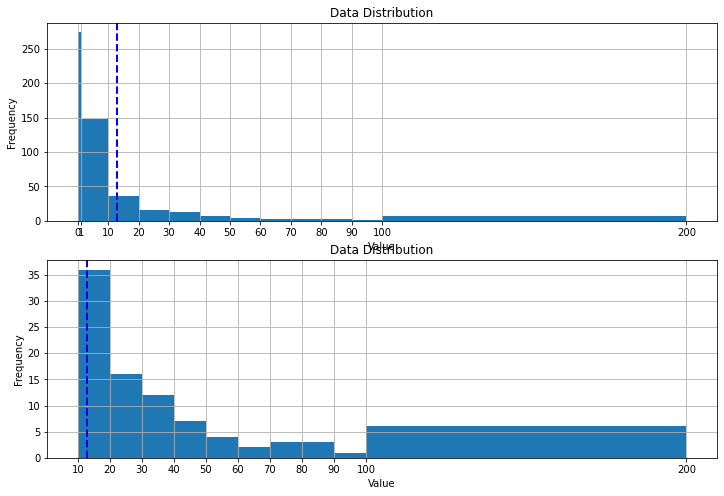

In [9]:
# Get the variable to examine
histData = forestFires['area']

meanVal = histData.mean()

# Create a Figure
plt.figure(figsize=(12,8))

plt.subplot(2,1,1)
plt.hist(histData, bins=[0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200])
plt.axvline(x=meanVal, color = 'blue', linestyle='dashed', linewidth = 2)
plt.title('Data Distribution')
plt.xlabel('Value')
plt.xticks(ticks=[0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200])
plt.ylabel('Frequency')
plt.grid(True)


print('Of the 500 values, more than 250 are between 0 and 1')
print('About 150 are between 1 and 10')
print('Let us try another histogram with those values removed')

plt.subplot(2,1,2)
plt.hist(histData, bins=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200])
plt.axvline(x=meanVal, color = 'blue', linestyle='dashed', linewidth = 2)
plt.title('Data Distribution')
plt.xlabel('Value')
plt.xticks(ticks=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200])
plt.ylabel('Frequency')
plt.grid(True)

plt.show()

### The burn area values are really skewed.

In [12]:
print('The number of records with zero burnt area is:  {}'
      .format(len(forestFires[forestFires['area'] == 0])))

print('The number of records with non zero burnt area is:  {}'
      .format(len(forestFires[forestFires['area'] != 0])))

print("The number of records with burnt area between 0 and 1 hectares is:  {}"
      .format(len(forestFires.loc[(forestFires['area'] > 0) & (forestFires['area'] <= 1)])))

The number of records with zero burnt area is:  247
The number of records with non zero burnt area is:  270
The number of records with burnt area between 0 and 1 hectares is:  27


In [13]:
limits = [10, 50, 100, 200, 500, 1000, 1100]

for each in limits:
    
    print('Burnt area more than {} hectares is:  {}'
          .format(each, len(forestFires[forestFires['area'] > each])))

Burnt area more than 10 hectares is:  95
Burnt area more than 50 hectares is:  24
Burnt area more than 100 hectares is:  11
Burnt area more than 200 hectares is:  5
Burnt area more than 500 hectares is:  2
Burnt area more than 1000 hectares is:  1
Burnt area more than 1100 hectares is:  0


#### This gives us a slightly better idea

#### Explore the distribution of other values

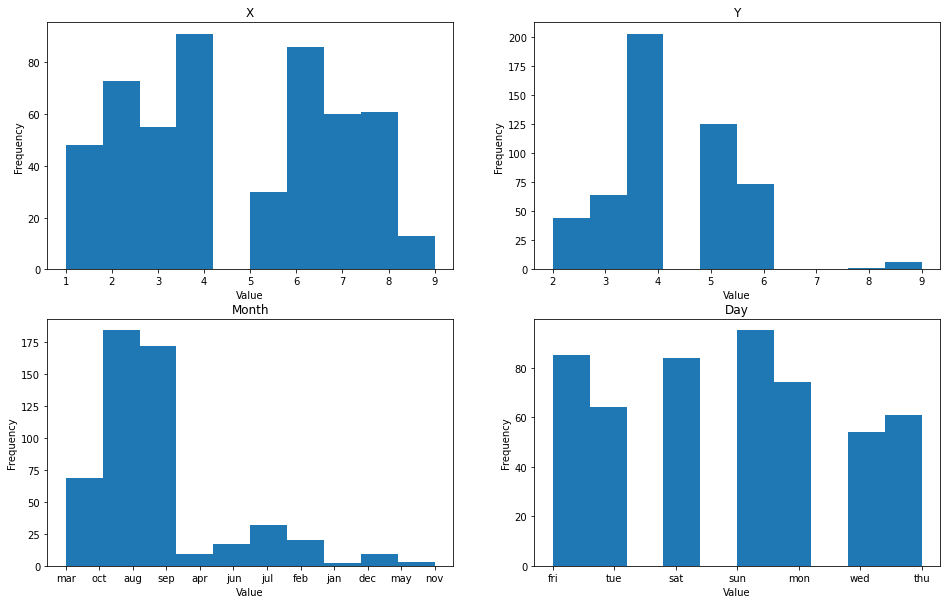

In [14]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.hist(forestFires['X'])
plt.grid(False)
plt.title('X')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(forestFires['Y'])
plt.grid(False)
plt.title('Y')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(forestFires['month'])
plt.grid(False)
plt.title('Month')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(forestFires['day'])
plt.grid(False)
plt.title('Day')
plt.xlabel('Value')
plt.ylabel('Frequency')


plt.show()

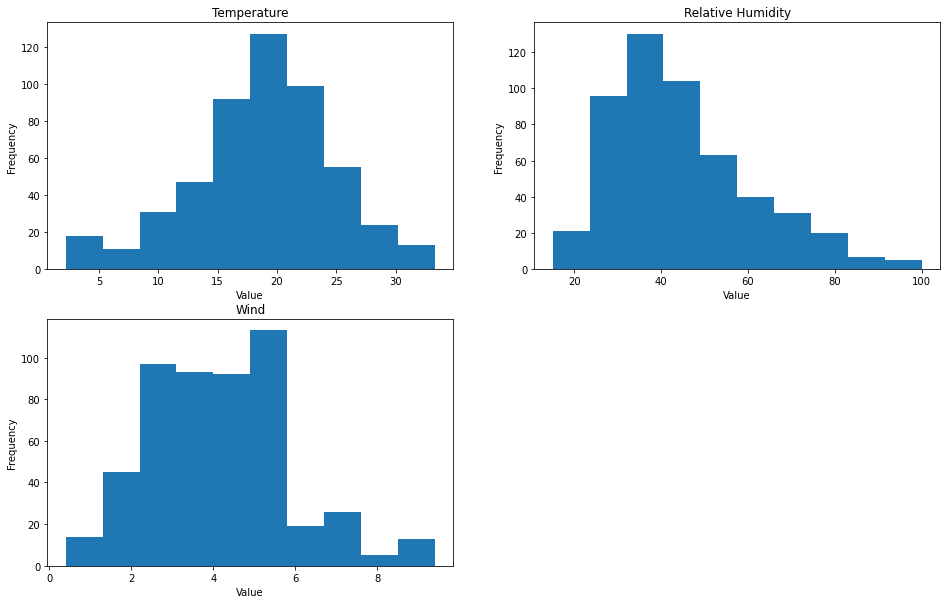

In [15]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.hist(forestFires['temp'])
plt.grid(False)
plt.title('Temperature')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(forestFires['RH'])
plt.grid(False)
plt.title('Relative Humidity')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(forestFires['wind'])
plt.grid(False)
plt.title('Wind')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

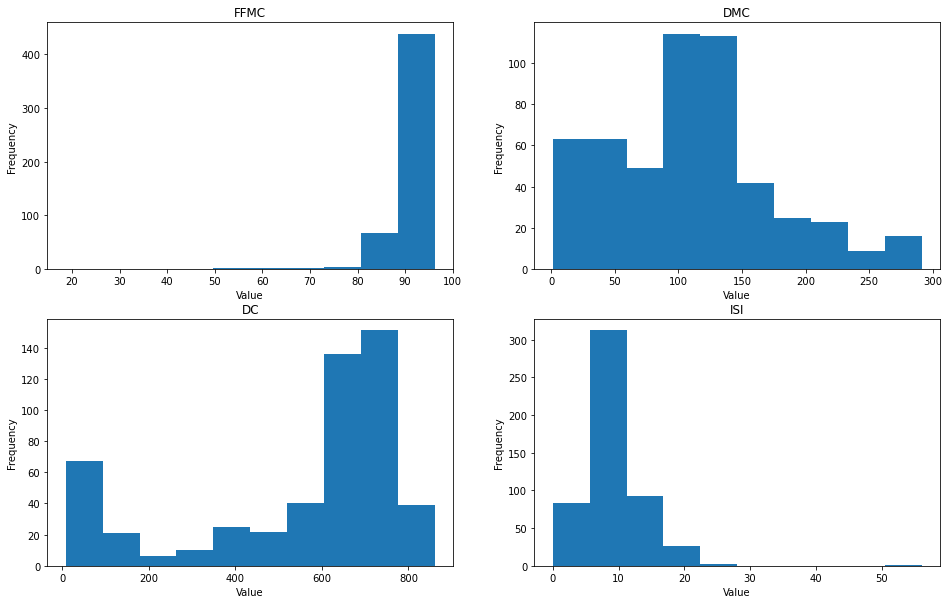

In [16]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.hist(forestFires['FFMC'])
plt.grid(False)
plt.title('FFMC')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(forestFires['DMC'])
plt.grid(False)
plt.title('DMC')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(forestFires['DC'])
plt.grid(False)
plt.title('DC')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(forestFires['ISI'])
plt.grid(False)
plt.title('ISI')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.show()

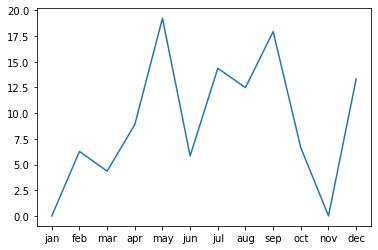

In [17]:
months = {'jan' : 0, 'feb' : 1, 'mar' : 2, 'apr' : 3, 'may' : 4, 'jun' : 5, 'jul' : 6,
               'aug' : 7, 'sep' : 8, 'oct' : 9, 'nov' : 10, 'dec' : 11}

plt.plot(forestFires[['month', 'area']].groupby(by='month').agg('mean').sort_values(by='month', key = lambda x: x.map(months)))
plt.show()

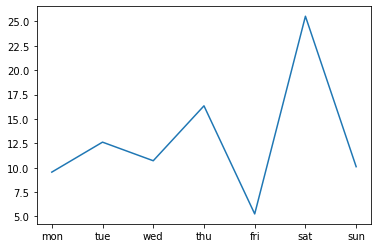

In [18]:
months = {'mon' : 0, 'tue' : 1, 'wed' : 2, 'thu' : 3, 'fri' : 4, 'sat' : 5, 'sun' : 6}

plt.plot(forestFires[['day', 'area']].groupby(by='day').agg('mean').sort_values(by='day', key = lambda x: x.map(months)))
plt.show()

#### There is no strong pattern or correlation between month/Day and Area. Therefore it isn't worth converting these categorical variables to one hot encodings. That will increase the number of predictors by 19 variables and that is too many on top of the 7 we already have

### Correlation between the properties

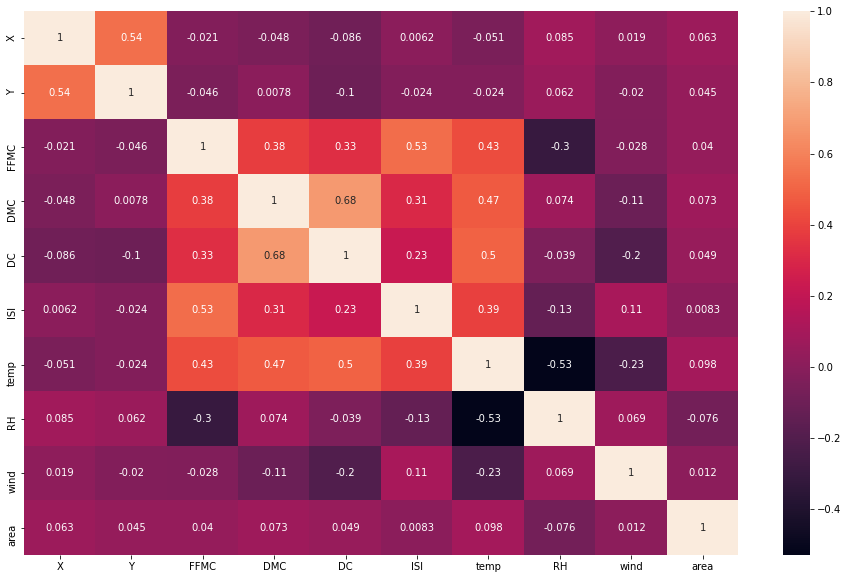

In [19]:
plt.figure(figsize=(16, 10))
corrMatrix = forestFires.corr()
sb.heatmap(corrMatrix, annot=True)
plt.show()

#### Train/Test split both the datasets

In [20]:
X, Y = forestFires[['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind']], forestFires[['area']]

In [21]:
XTrain, XTest, YTrain, YTest = train_test_split(X, Y, test_size=0.20, random_state=9892)

#### Some transformations

#### Power Transforms

#### Standard Scaler

In [22]:
pt = PowerTransformer()
ptY = PowerTransformer()

pt.fit(XTrain)
ptY.fit(YTrain)

#Train Data

XTrain_PT = pd.DataFrame(pt.transform(XTrain),
                         columns=['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind'])

# YTrain_PT = pd.DataFrame(ptY.transform(YTrain), columns=['area'])


#Test Data

XTest_PT = pd.DataFrame(pt.transform(XTest),
                        columns=['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind'])

# YTest_PT = pd.DataFrame(ptY.transform(YTest), columns=['area'])

In [23]:
sc = StandardScaler()

sc.fit(XTrain)

XTrain_SC = pd.DataFrame(sc.transform(XTrain),
                        columns=['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind'])

XTest_SC = pd.DataFrame(sc.transform(XTest), columns=['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind'])

#### Visualizing data before and after transformations

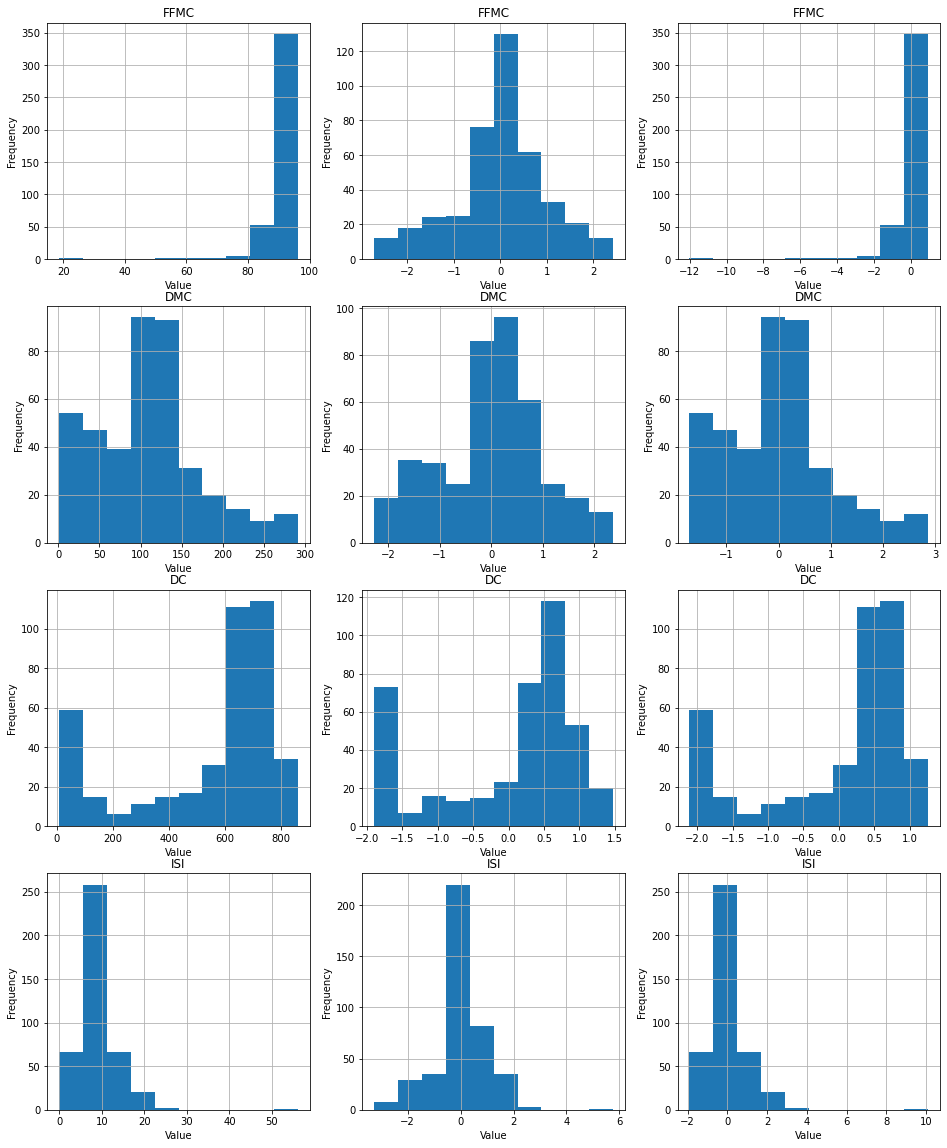

In [24]:
plt.figure(figsize=(16, 20))

plt.subplot(4, 3, 1)
plt.hist(XTrain['FFMC'])
plt.grid(True)
plt.title('FFMC')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(4, 3, 2)
plt.hist(XTrain_PT['FFMC'])
plt.grid(True)
plt.title('FFMC')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(4, 3, 3)
plt.hist(XTrain_SC['FFMC'])
plt.grid(True)
plt.title('FFMC')
plt.xlabel('Value')
plt.ylabel('Frequency')


plt.subplot(4, 3, 4)
plt.hist(XTrain['DMC'])
plt.grid(True)
plt.title('DMC')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(4, 3, 5)
plt.hist(XTrain_PT['DMC'])
plt.grid(True)
plt.title('DMC')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(4, 3, 6)
plt.hist(XTrain_SC['DMC'])
plt.grid(True)
plt.title('DMC')
plt.xlabel('Value')
plt.ylabel('Frequency')


plt.subplot(4, 3, 7)
plt.hist(XTrain['DC'])
plt.grid(True)
plt.title('DC')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(4, 3, 8)
plt.hist(XTrain_PT['DC'])
plt.grid(True)
plt.title('DC')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(4, 3, 9)
plt.hist(XTrain_SC['DC'])
plt.grid(True)
plt.title('DC')
plt.xlabel('Value')
plt.ylabel('Frequency')


plt.subplot(4, 3, 10)
plt.hist(XTrain['ISI'])
plt.grid(True)
plt.title('ISI')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(4, 3, 11)
plt.hist(XTrain_PT['ISI'])
plt.grid(True)
plt.title('ISI')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(4, 3, 12)
plt.hist(XTrain_SC['ISI'])
plt.grid(True)
plt.title('ISI')
plt.xlabel('Value')
plt.ylabel('Frequency')


plt.show()

In [25]:
print ('Training Set: {} rows\n\nTest Set: {} rows'.format(XTrain.shape[0], XTest.shape[0]))

Training Set: 413 rows

Test Set: 104 rows


### Model Evaluation

#### Predictions

#### R Squared, MAE, RMSE

In [26]:
def regressionResults(YTrue, predictions):

    # Regression metrics
    MAE=metrics.mean_absolute_error(YTrue, predictions) 
    RMSE=metrics.mean_squared_error(YTrue, predictions, squared=False) 
    r2=metrics.r2_score(YTrue, predictions)

    print('\nR Squared: ', round(r2,4))
    print('\nMAE: ', round(MAE,4))
    print('\nRMSE: ', round(RMSE,4))

#### Residuals

In [27]:
def residualPlots(YTrue, predictions):

    plt.figure(figsize=(15,10))

    plt.subplot(2,2,1)
    sb.residplot(x = predictions, y = YTrue, lowess = True, line_kws={'color':'red'})
    plt.xlabel('Fitted Values')
    plt.title('Residual Plot')

    plt.subplot(2,2,2)
    residuals = YTrue - predictions
    scipy.stats.probplot(residuals.reshape(-1), dist="norm", plot=plt)
    
    
    plt.subplot(2,2,3)
    plt.scatter(YTrue, predictions)
    plt.xlabel('Actual Labels')
    plt.ylabel('Predicted Labels')


    plt.show()

### Regression Models

#### Linear Regression


R Squared:  0.0275

MAE:  20.4458

RMSE:  72.567


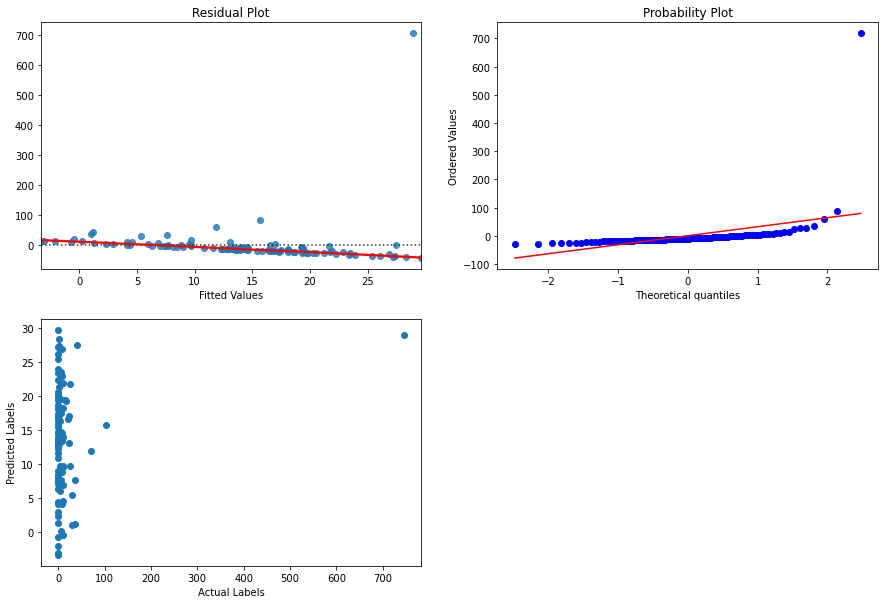

In [32]:
Model_LinearRegression = None
Model_LinearRegression = LinearRegression()

Model_LinearRegression.fit(X=XTrain, y=YTrain)

predictions = None
predictions = Model_LinearRegression.predict(XTest)

regressionResults(YTest.values, predictions)
residualPlots(YTest.values, predictions)

#### Ridge Regression


R Squared:  0.0275

MAE:  20.4453

RMSE:  72.5671


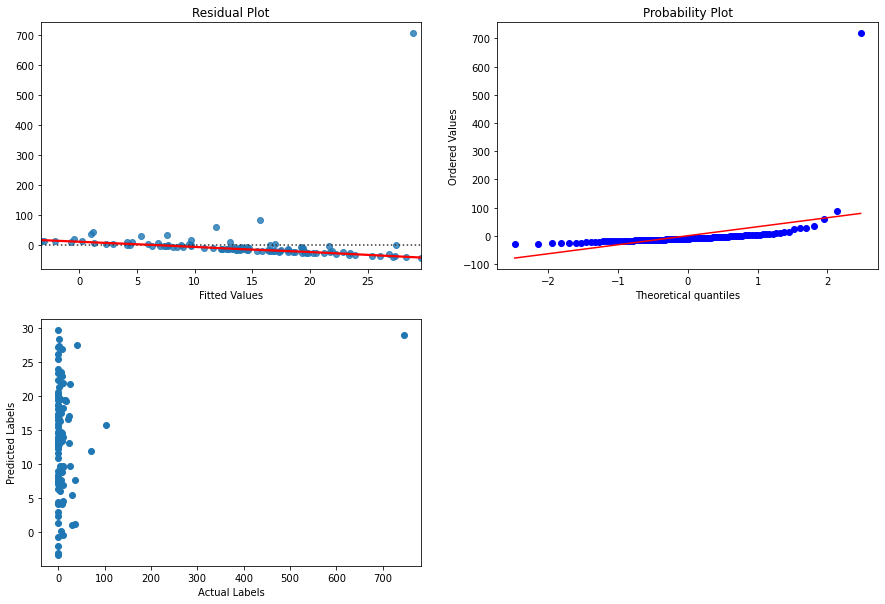

In [33]:
Model_Ridge = None
Model_Ridge = Ridge()

Model_Ridge.fit(X=XTrain, y=YTrain)

predictions = None
predictions = Model_Ridge.predict(XTest)

regressionResults(YTest.values, predictions)
residualPlots(YTest.values, predictions)

#### SGD Regressor

D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



R Squared:  -3.9011539876075655e+24

MAE:  133572916510131.53

RMSE:  145345097239207.06


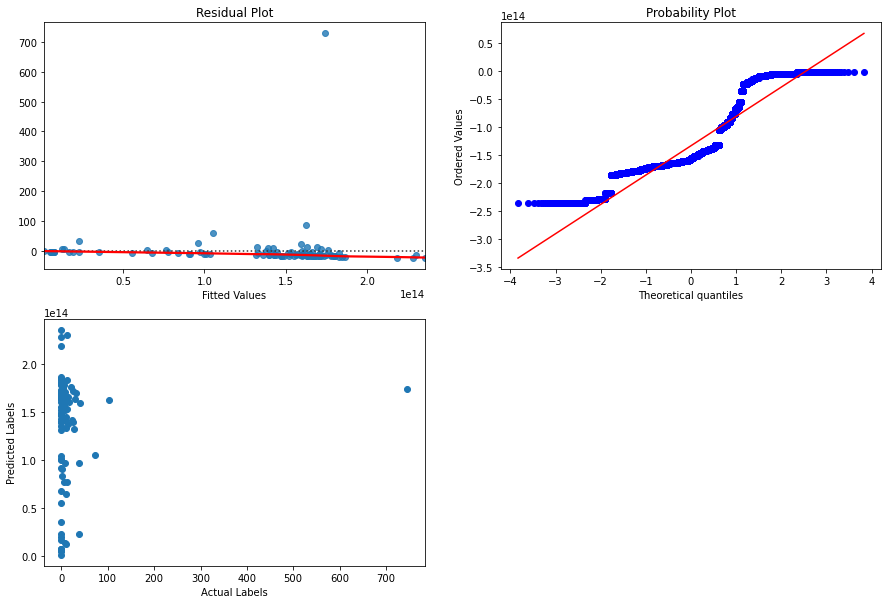

In [34]:
Model_SGD = None
Model_SGD = SGDRegressor()

Model_SGD.fit(X=XTrain, y=YTrain)

predictions = None
predictions = Model_SGD.predict(XTest)

regressionResults(YTest.values, predictions)
residualPlots(YTest.values, predictions)

#### ElasticNet


R Squared:  0.0264

MAE:  20.2977

RMSE:  72.6112


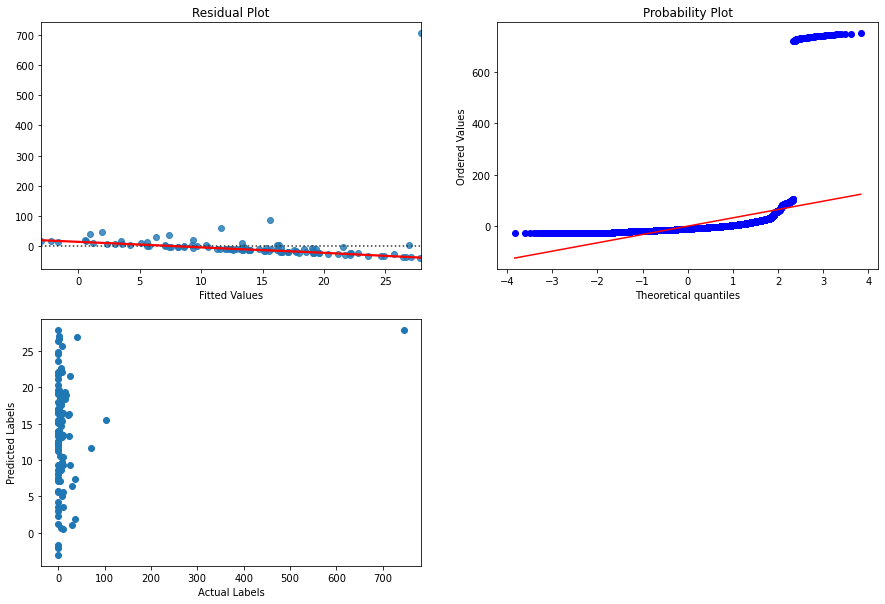

In [35]:
Model_ElasticNet = None
Model_ElasticNet = ElasticNet()

Model_ElasticNet.fit(X=XTrain, y=YTrain)

predictions = None
predictions = Model_ElasticNet.predict(XTest)

regressionResults(YTest.values, predictions)
residualPlots(YTest.values, predictions)

#### Lasso


R Squared:  0.0265

MAE:  20.2971

RMSE:  72.6065


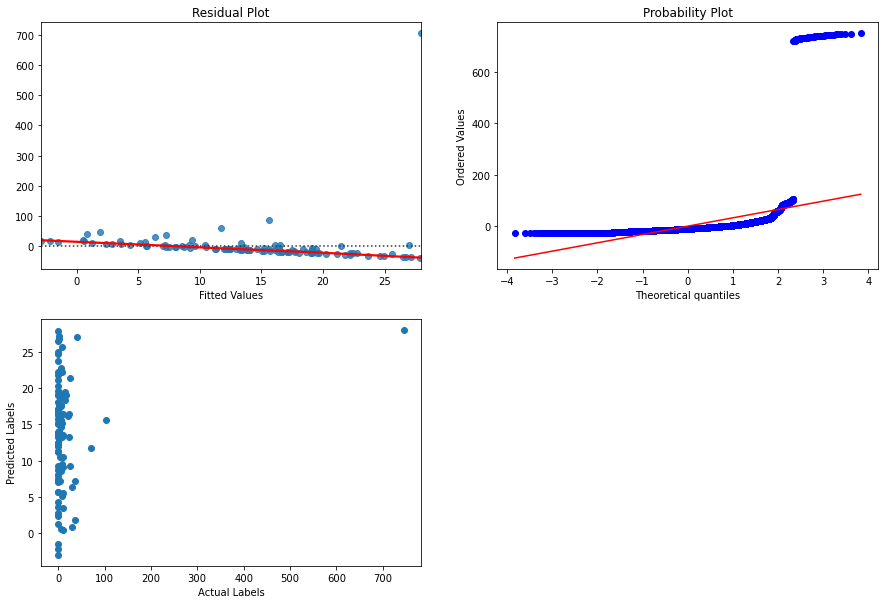

In [36]:
Model_Lasso = None
Model_Lasso = Lasso()

Model_Lasso.fit(X=XTrain, y=YTrain)

predictions = None
predictions = Model_Lasso.predict(XTest)

regressionResults(YTest.values, predictions)
residualPlots(YTest.values, predictions)

#### Huber Regressor

D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\sklearn\linear_model\_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)



R Squared:  -0.0266

MAE:  14.2135

RMSE:  74.5616


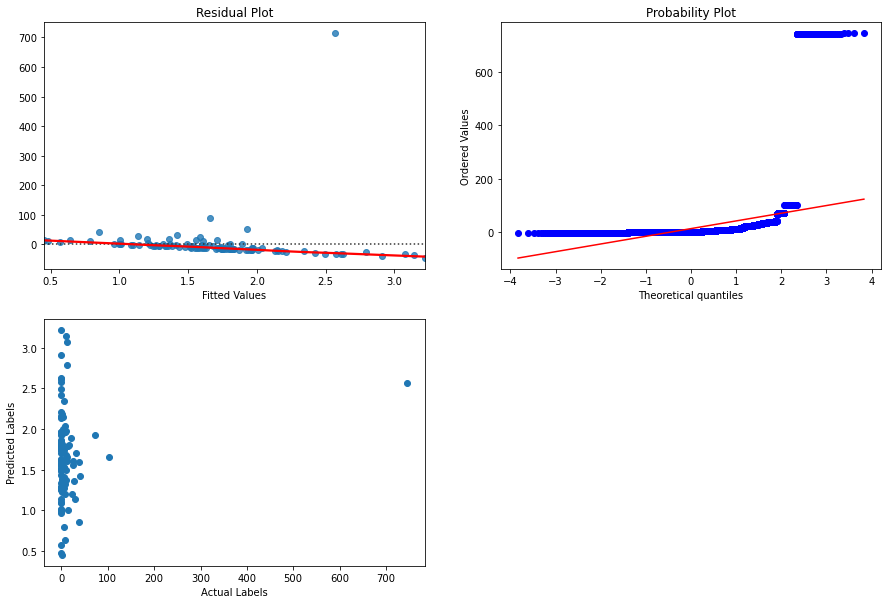

In [37]:
Model_Huber = None
Model_Huber = HuberRegressor()

Model_Huber.fit(X=XTrain, y=YTrain)

predictions = None
predictions = Model_Huber.predict(XTest)

regressionResults(YTest.values, predictions)
residualPlots(YTest.values, predictions)

### Regression (Feature Selection)

#### Recursive Feature Elimination

In [38]:
RFESelector = RFE(estimator = LinearRegression(), n_features_to_select = 4)

RFESelector.fit(XTrain, YTrain)

print(XTrain.columns[RFESelector.get_support()])

XTrainRFE = pd.DataFrame(RFESelector.transform(XTrain), columns = XTrain.columns[RFESelector.get_support()])

XTestRFE = pd.DataFrame(RFESelector.transform(XTest), columns = XTest.columns[RFESelector.get_support()])

Index(['X', 'ISI', 'temp', 'wind'], dtype='object')



R Squared:  0.0203

MAE:  20.4794

RMSE:  72.837


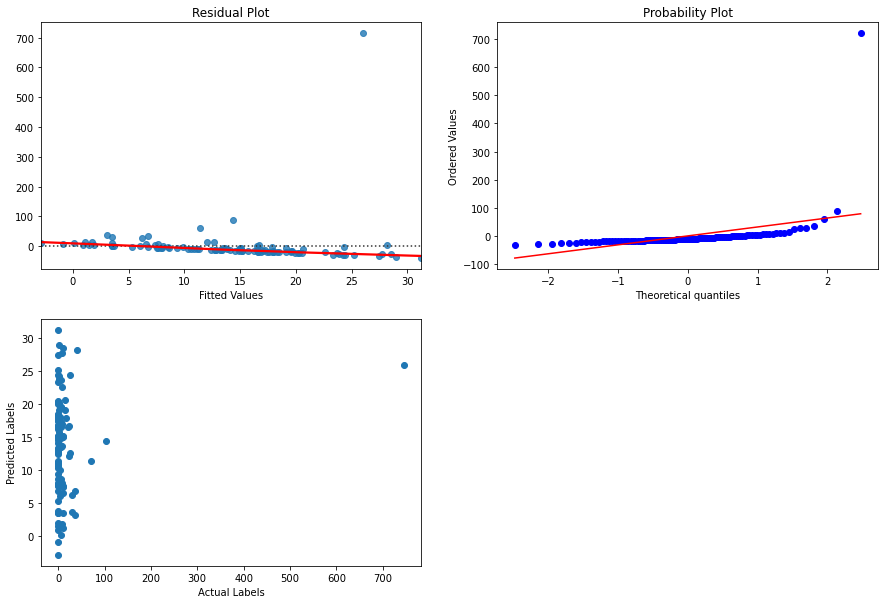

In [45]:
Model_RFE = None
Model_RFE = LinearRegression()

Model_RFE.fit(X=XTrainRFE, y=YTrain)

predictions = None
predictions = Model_RFE.predict(XTestRFE)

regressionResults(YTest.values, predictions)
residualPlots(YTest.values, predictions)

####  Sequential Feature Selection

In [46]:
SFSSelector = SequentialFeatureSelector(estimator=LinearRegression(), n_features_to_select = 4, direction ='backward')

SFSSelector.fit(XTrain, YTrain)

print(XTrain.columns[SFSSelector.get_support()])

XTrainSFS = pd.DataFrame(SFSSelector.transform(XTrain), columns = XTrain.columns[SFSSelector.get_support()])

XTestSFS = pd.DataFrame(SFSSelector.transform(XTest), columns = XTest.columns[SFSSelector.get_support()])

Index(['X', 'Y', 'ISI', 'wind'], dtype='object')



R Squared:  0.0055

MAE:  19.105

RMSE:  73.3846


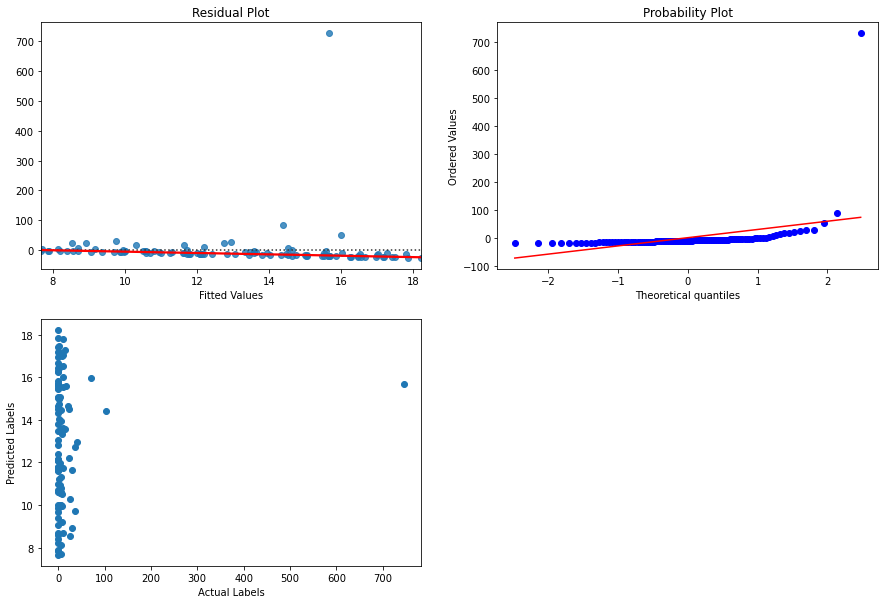

In [54]:
Model_SFS = None
Model_SFS = LinearRegression()

Model_SFS.fit(X=XTrainSFS, y=YTrain)

predictions = None
predictions = Model_SFS.predict(XTestSFS)

regressionResults(YTest.values, predictions)
residualPlots(YTest.values, predictions)

### Regression (Transformations)

#### Power Transform


R Squared:  0.0302

MAE:  20.3854

RMSE:  72.4667


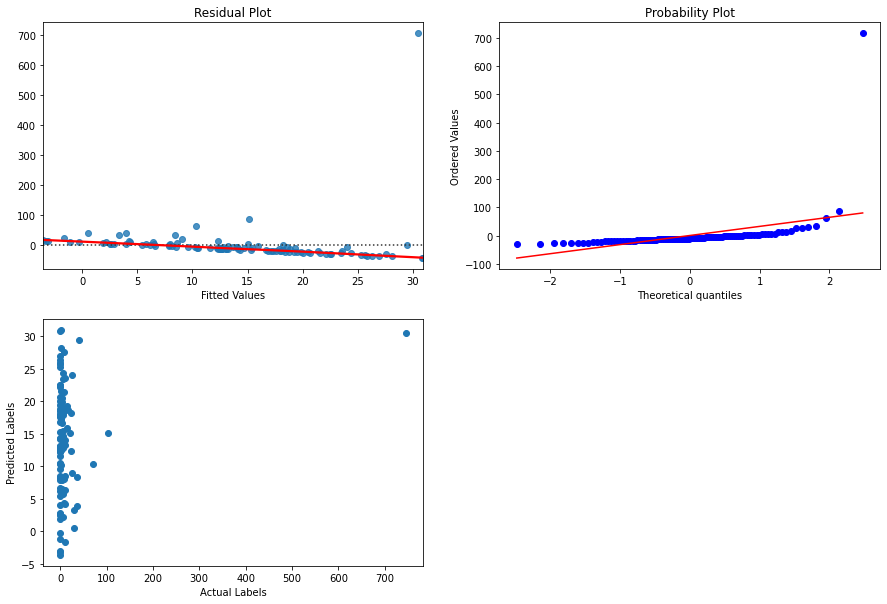

In [55]:
Model_LinearRegression_PT = LinearRegression()

Model_LinearRegression_PT.fit(X=XTrain_PT, y=YTrain)
    
predictions = Model_LinearRegression_PT.predict(XTest_PT)

# actualPred = ptY.inverse_transform(predictions)

regressionResults(YTest.values, predictions)
residualPlots(YTest.values, predictions)


R Squared:  0.0206

MAE:  19.4773

RMSE:  72.826


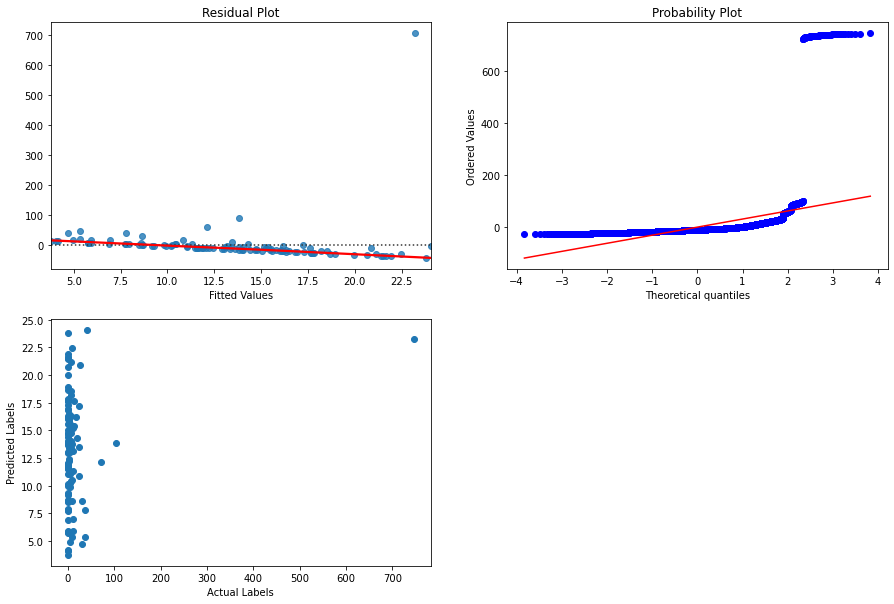

In [62]:
Model_Elastic_PT = ElasticNet()

Model_Elastic_PT.fit(X=XTrain_PT, y=YTrain)
    
predictions = Model_Elastic_PT.predict(XTest_PT)

# actualPred = ptY.inverse_transform(predictions)

regressionResults(YTest.values, predictions)
residualPlots(YTest.values, predictions)

#### Standard Scale


R Squared:  0.0275

MAE:  20.4458

RMSE:  72.567


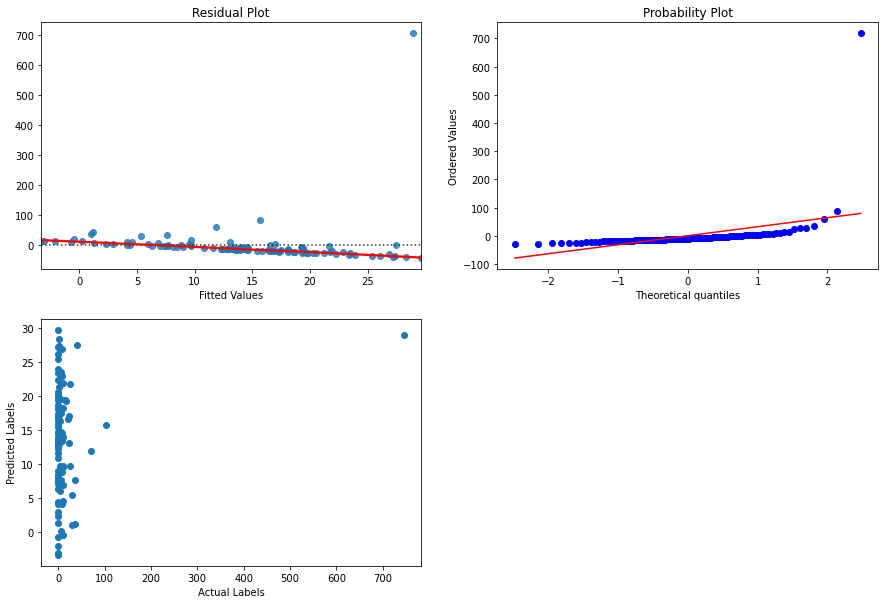

In [64]:
Model_LinearRegression_SC = LinearRegression()

Model_LinearRegression_SC.fit(X=XTrain_SC, y=YTrain)
    
predictions = Model_LinearRegression_SC.predict(XTest_SC)

# actualPred = ptY.inverse_transform(predictions)

regressionResults(YTest.values, predictions)
residualPlots(YTest.values, predictions)


R Squared:  0.019

MAE:  19.538

RMSE:  72.8857


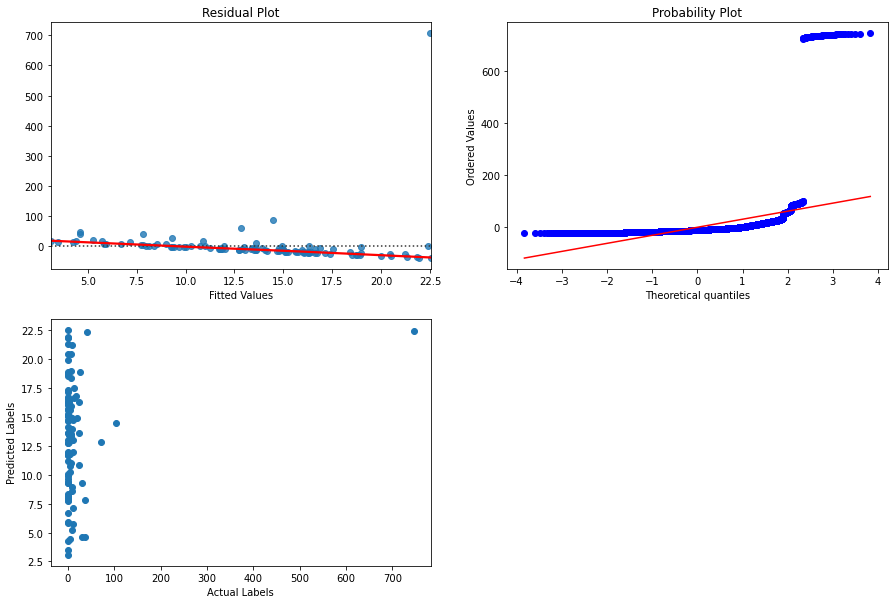

In [65]:
Model_Elastic_SC = ElasticNet()

Model_Elastic_SC.fit(X=XTrain_SC, y=YTrain)
    
predictions = Model_Elastic_SC.predict(XTest_SC)

# actualPred = ptY.inverse_transform(predictions)

regressionResults(YTest.values, predictions)
residualPlots(YTest.values, predictions)

### SVM

D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "



R Squared:  0.015

MAE:  18.0474

RMSE:  73.0323


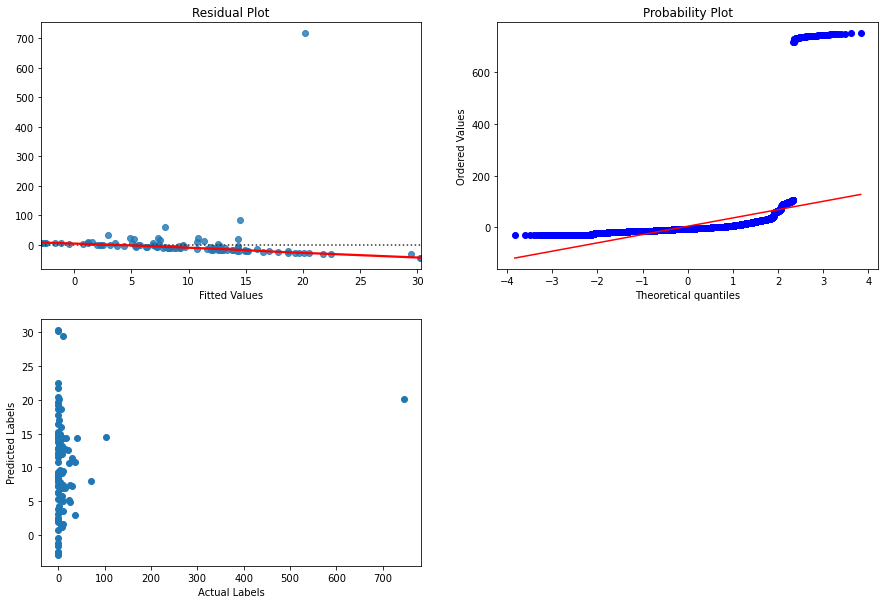

In [69]:
Linear_SVM = None
Linear_SVM = LinearSVR()

Linear_SVM.fit(X=XTrain, y=YTrain)

predictions = None
predictions = Linear_SVM.predict(XTest)

regressionResults(YTest.values, predictions)
residualPlots(YTest.values, predictions)

D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



R Squared:  -0.0325

MAE:  14.156

RMSE:  74.7735


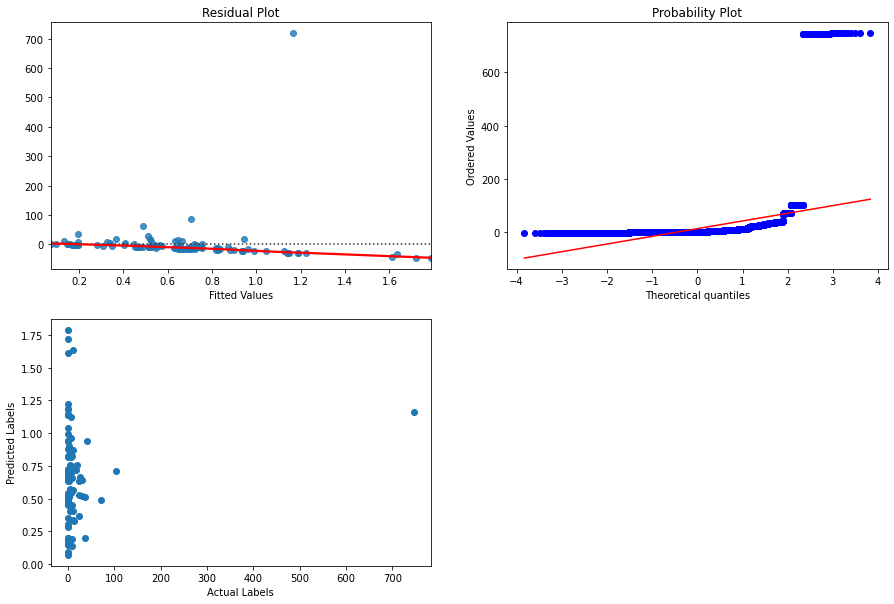

In [70]:
SVM = None
SVM = SVR()

SVM.fit(X=XTrain, y=YTrain)

predictions = None
predictions = SVM.predict(XTest)

regressionResults(YTest.values, predictions)
residualPlots(YTest.values, predictions)

In [ ]:
BaggingRegressor, GradientBoostingRegressor, RandomForestRegressor, DecisionTreeRegressor

### Decision Tree Regressor


R Squared:  -0.0728

MAE:  23.9936

RMSE:  76.2181


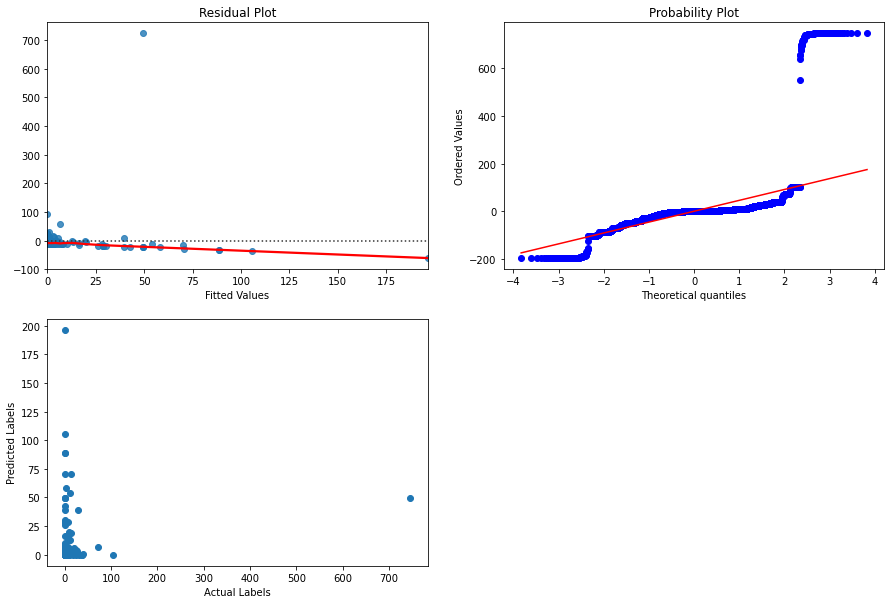

In [73]:
decisionTree = None
decisionTree = DecisionTreeRegressor()

decisionTree.fit(X=XTrain, y=YTrain)

predictions = None
predictions = decisionTree.predict(XTest)

regressionResults(YTest.values, predictions)
residualPlots(YTest.values, predictions)

### Ensemble Methods

D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



R Squared:  -0.1699

MAE:  24.1011

RMSE:  79.5945


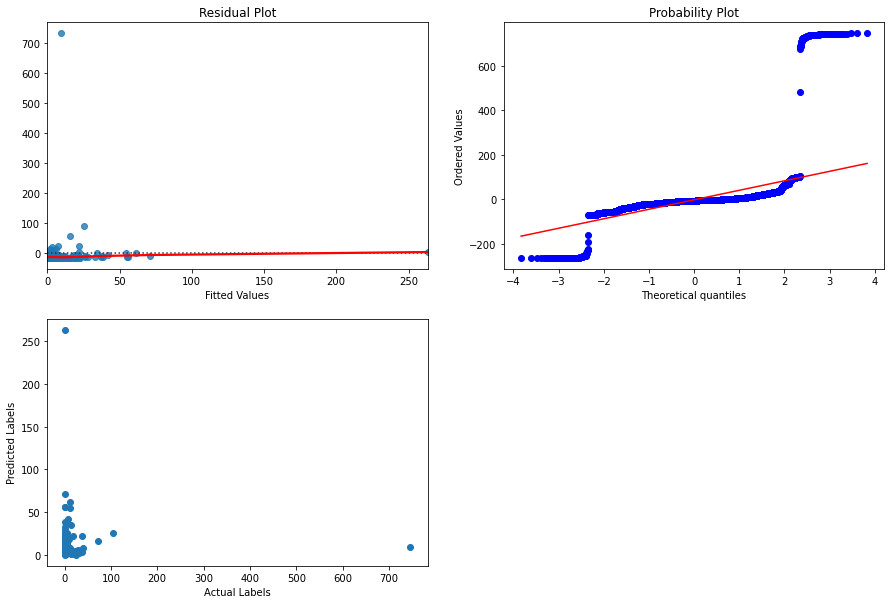

In [74]:
bagging = None
bagging = BaggingRegressor()

bagging.fit(X=XTrain, y=YTrain)

predictions = None
predictions = bagging.predict(XTest)

regressionResults(YTest.values, predictions)
residualPlots(YTest.values, predictions)

D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)



R Squared:  -0.0601

MAE:  20.5545

RMSE:  75.7665


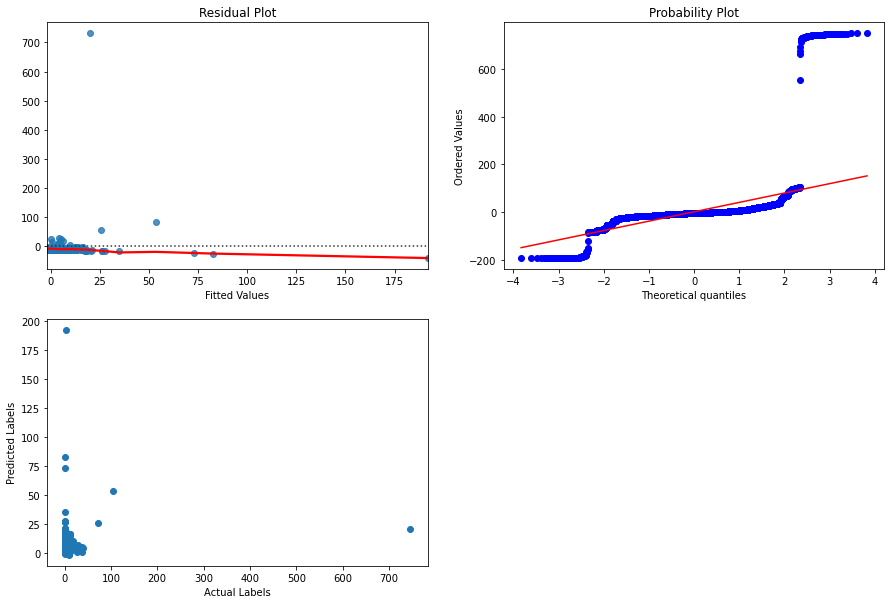

In [75]:
gradBoost = None
gradBoost = GradientBoostingRegressor()

gradBoost.fit(X=XTrain, y=YTrain)

predictions = None
predictions = gradBoost.predict(XTest)

regressionResults(YTest.values, predictions)
residualPlots(YTest.values, predictions)

<ipython-input-76-eaeae801ae6c>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  randomForest.fit(X=XTrain, y=YTrain)



R Squared:  -0.0298

MAE:  21.9661

RMSE:  74.6748


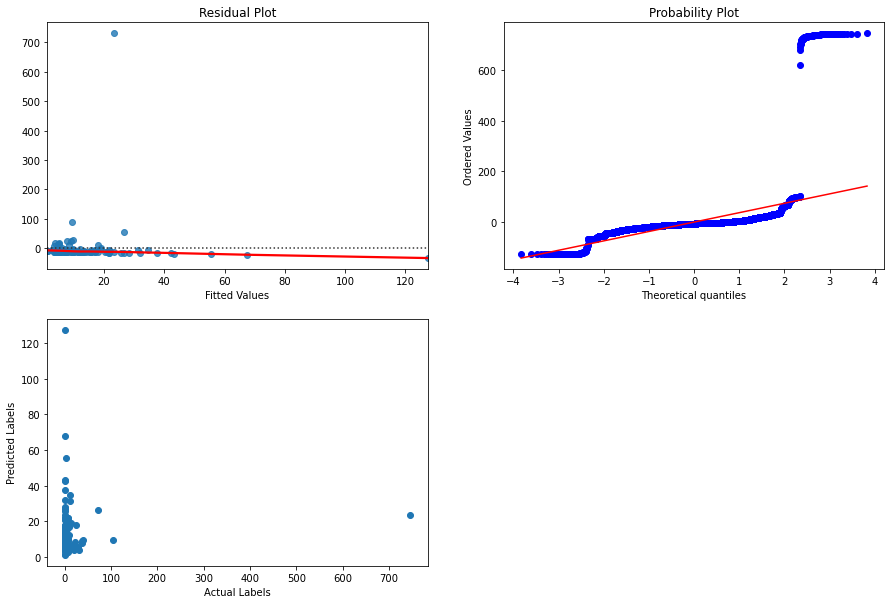

In [76]:
randomForest = None
randomForest = RandomForestRegressor()

randomForest.fit(X=XTrain, y=YTrain)

predictions = None
predictions = randomForest.predict(XTest)

regressionResults(YTest.values, predictions)
residualPlots(YTest.values, predictions)